# Setup

In [1]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-12 14:03:47.844699: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
config = json.load(open("./configs/mnn_em_bert_amazon_lr_1e-05.json"))

In [7]:
config["data"]["path"] = "/mnt/azmnt/abo"

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=False,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
# data = data.sample(10000)
data

Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,ukb07sz17tswamazon brand - solimo designer whi...,47/47a999d7.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07th383jfamazon brand - symbol me...,75/756a2d43.jpg,CELLULAR_PHONE_CASE,0
2,mobile coverb07t8q1hx8amazon brand - solimo de...,e3/e305fa26.jpg,CELLULAR_PHONE_CASE,1
3,designer caseb07xydgsn8amazon brand - solimo d...,0c/0ca9a99d.jpg,CELLULAR_PHONE_CASE,1
4,"mobile coverb07kqkpkdz365 everyday value, orga...",d2/d2e504ef.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168162,back coverb0857l28lqamazon brand - solimo desi...,77/77082e28.jpg,CELLULAR_PHONE_CASE,1
168163,mobile coverb07fqynbh8amazon brand - solimo de...,d8/d8846fac.jpg,FINEEARRING,0
168164,back coverb07tcwtzbqamazon brand - solimo desi...,06/06705fa2.jpg,GROCERY,0
168165,ainersb07tg4g4fmmovian adour 3-door shoe cabin...,43/43c409c6.jpg,SHOES,0


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing (only explorative purposes)

## generate text embeddings directly with BERT

In [11]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
# text = bert_preprocess_model(text)

# print(f'Keys       : {list(text.keys())}')
# print(f'Shape      : {text["input_word_ids"].shape}')
# print(f'Word Ids   : {text["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text["input_mask"][0, :12]}')
# print(f'Type Ids   : {text["input_type_ids"][0, :12]}')

In [15]:
# text

In [16]:
# text = bert_model(text)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{text["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{text["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{text["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{text["sequence_output"][0, :12]}')

In [17]:
# text = text["pooled_output"]
# text.shape

# Image processing

In [18]:
from utils.img_processing import load_img_model, create_embeddings_from

In [19]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [20]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=1024)

Found 168162 validated image filenames.


In [21]:
img.shape

(168162, 576)

# Save embeddings

In [20]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/bert/{img_model.name}")

In [23]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [48]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,back coverb0748pwdqfamazon brand - vedaka prem...,79/7935dd80.jpg,CELLULAR_PHONE_CASE,0
1,cellphonecoverb08563ghfnamazon brand - solimo ...,81/8178b5a4.jpg,CELLULAR_PHONE_CASE,1
2,mobile coverb07t36tl3hamazon brand - solimo de...,3f/3f552f86.jpg,CELLULAR_PHONE_CASE,1
3,back coverb0854fkpjlamazon brand - solimo desi...,b2/b2ba9207.jpg,CELLULAR_PHONE_CASE,1
4,mobile coverb081hmnss3amazon brand - solimo de...,c6/c6201b94.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168157,mobile coverb08569hdhgamazon brand - solimo de...,3a/3ac33617.jpg,SHOES,0
168158,mobile coverb07t9tqg5qamazon brand - solimo de...,01/012b83e4.jpg,ACCESSORY,0
168159,mobile coverb07t14qb3mamazonbasics vehicles ca...,c0/c03f0de6.jpg,CELLULAR_PHONE_CASE,0
168160,formal shoes for mens leatherb07tg4xxq1amazon ...,58/5826fe0d.jpg,CELLULAR_PHONE_CASE,0


In [49]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168162, 576)

In [50]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168162,)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [51]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [52]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [57]:
img_train = img[train.index]
img_test = img[test.index]

text_train = train["description"]
text_test = test["description"]

# Build BERT model (only explorative purposes)

In [58]:
text_input = tf.keras.layers.Input(shape=(()), dtype=tf.string)

x = bert_preprocess_model(text_input)

text_output = bert_model(x)["pooled_output"]

some_model = tf.keras.models.Model(text_input, text_output)

some_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_3[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [59]:
some_model(test[:5]["description"])

<tf.Tensor: shape=(5, 768), dtype=float32, numpy=
array([[-0.7044544 , -0.42157865, -0.9286306 , ..., -0.90065324,
        -0.6374589 ,  0.5993884 ],
       [-0.733945  , -0.4068216 , -0.9083627 , ..., -0.727572  ,
        -0.6238711 ,  0.7451195 ],
       [-0.85614777, -0.45530844, -0.97805583, ..., -0.9448009 ,
        -0.60280013,  0.7229367 ],
       [-0.8480447 , -0.5102949 , -0.98738486, ..., -0.9601255 ,
        -0.5691691 ,  0.56043285],
       [-0.86908203, -0.48437256, -0.9764273 , ..., -0.9234282 ,
        -0.5657076 ,  0.61160105]], dtype=float32)>

# Save Char CNN config

Not needed, as we use BERT for text embeddings instead

In [60]:
# from models.char_cnn_zhang import CharCNNZhang

In [61]:
# char_cnn_config = {
#     "input_size": config["data"]["input_size"],
#     "embedding_size": len(tk.word_index),
#     "conv_layers": config["char_cnn_zhang"]["conv_layers"],
#     "fc_layers": config["char_cnn_zhang"]["fc_layers"],
#     "output_size": config["char_cnn_zhang"]["output_size"],
#     "embedding_weights": weights
# }

In [62]:
# char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [63]:
# from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CosineSimilarity


class MNNEMBert(object):
    def __init__(
            self, head_config, combined_fc_layers, learning_rate,
            metrics=["recall", "precision", "binary_accuracy", "cosine_similarity"],
            loss='binary_crossentropy', name="MNN_EM") -> None:
        self.head_config = head_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        img_features = Input(
            shape=(self.head_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = Input(
            shape=(()), dtype=tf.string, name="Text_Input")

        x = _MNNEMHead(**self.head_config)

        x = x.model([img_features, text_features])

        # FC Layers
        for i, comb_fl in enumerate(self.combined_fc_layers, 1):
            x = Dense(comb_fl, activation='relu',
                      name=f"Combined_FC_{i}")(x)

        output = Dense(1, activation='sigmoid', name="Sigmoid")(x)
        model = Model(inputs=[img_features, text_features],
                      outputs=output, name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)
        self.model = model
        # print("MNN-EM model built: ")
        # self.model.summary()


class _MNNEMHead(object):
    def __init__(self, img_input_size, txt_input_size, img_fc_layers,
                 txt_fc_layers, extended):
        self.img_input_size = img_input_size
        self.txt_input_size = txt_input_size
        self.img_fc_layers = img_fc_layers
        self.txt_fc_layers = txt_fc_layers
        self.extended = extended
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.img_input_size),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.img_input_size,
                             self.img_fc_layers, self.extended, name="Image")

        output_img = img_cnn.model(img_features)

        # Image Input
        text_features = tf.keras.layers.Input(shape=(()), dtype=tf.string, name="Text_Input_Head_Outer")

        bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
        bert_model = hub.KerasLayer(tfhub_handle_encoder)

        x = bert_preprocess_model(text_features)

        x = bert_model(x)["pooled_output"]

        text_cnn = _CNNBranch(x.shape[1],
                             self.txt_fc_layers, self.extended, name="Text")

        output_text = text_cnn.model(x)

        # Element-wise product
        combined = Multiply(
            name="Element-wise_Multiplication")([output_img, output_text])

        model = Model(inputs=[img_features, text_features],
                      outputs=combined, name="MNN_EM_Head")

        self.model = model


class _CNNBranch(object):
    def __init__(self, input_size, fc_layers, extended, name):
        self.input_size = input_size
        self.fc_layers = fc_layers
        self.extended = extended
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        features = Input(shape=(self.input_size),
                         name=f"{self.name}_Input_Head_Inner")

        # fc + ReLU
        for i, fl in enumerate(
                self.fc_layers[: None if self.extended else -1],
                1):
            x = Dense(fl, activation='relu',
                      name=f"{self.name}_FC_{i}")(features if i == 1 else x)

        if not self.extended:
            # fc + L2 Norm
            x = Dense(
                self.fc_layers[-1],
                kernel_regularizer='l2', name=f"{self.name}_FC_last")(
                features if len(self.fc_layers) == 1 else x)

        output = BatchNormalization(name=f"{self.name}_Batch_Normalization")(x)

        model = Model(inputs=features, outputs=output, name=f"{self.name}_CNN")

        self.model = model

In [65]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [66]:
mnn_em = MNNEMBert(head_config=head_config,
               combined_fc_layers=config["model"]["combined_fc_layers"],
               learning_rate=config["model"]["training"]["learning_rate"],
               metrics=create_metrics(config["model"]["training"]["metrics"]))

In [67]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          111914241   ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Text_Input_Head_Outer (InputLa  [(None,)]         0           []                           

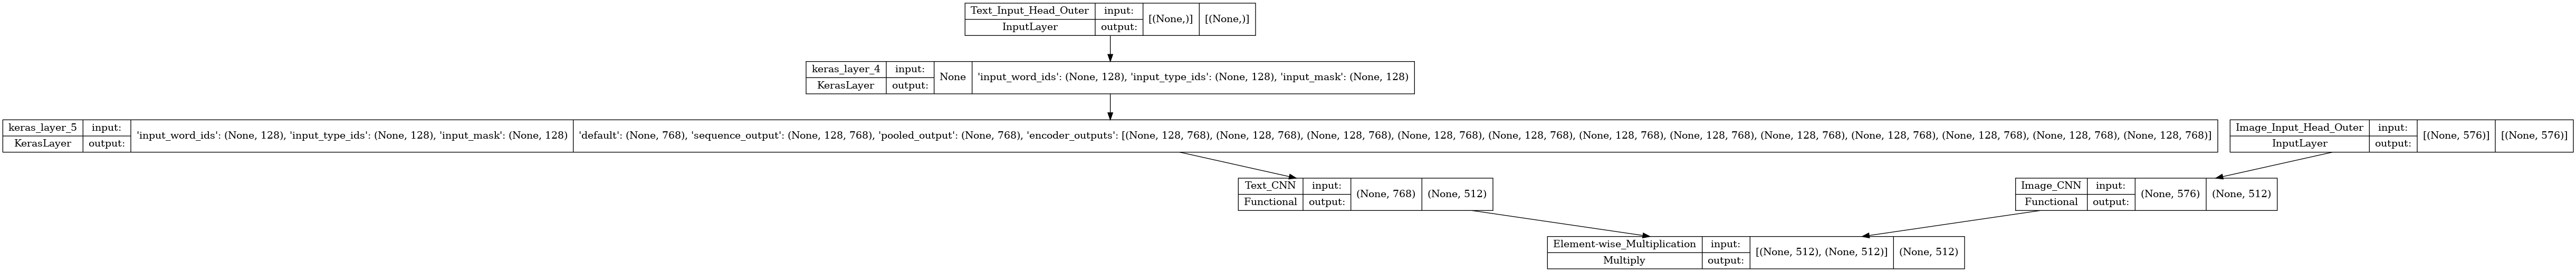

In [68]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

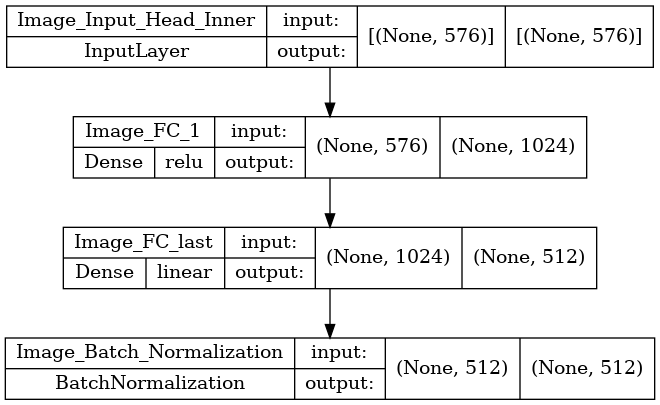

In [69]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[4],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

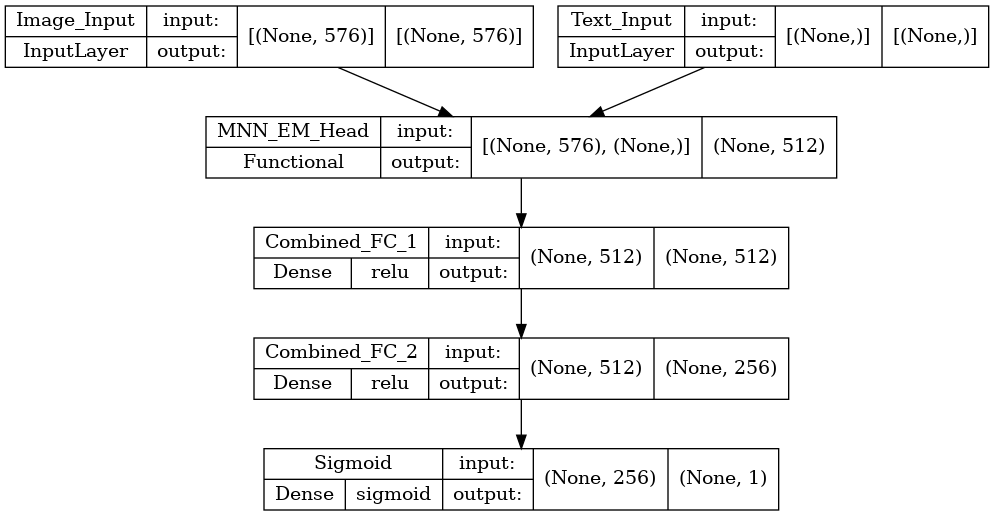

In [70]:
# Full model

tf.keras.utils.plot_model(mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [71]:
from utils.metrics import create_callbacks

In [72]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [73]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [74]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8512/8513 [============================>.] - ETA: 0s - loss: 7.3141 - recall: 0.8046 - precision: 0.7593 - binary_accuracy: 0.7660 - cosine_similarity: 0.5195

2023-06-12 14:16:34.625301: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 687s 80ms/step - loss: 7.3140 - recall: 0.8046 - precision: 0.7593 - binary_accuracy: 0.7660 - cosine_similarity: 0.5195 - val_loss: 4.0674 - val_recall: 0.8167 - val_precision: 0.8098 - val_binary_accuracy: 0.8068 - val_cosine_similarity: 0.5152
Epoch 2/10
8512/8513 [============================>.] - ETA: 0s - loss: 3.0517 - recall: 0.9090 - precision: 0.8578 - binary_accuracy: 0.8744 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 679s 80ms/step - loss: 3.0517 - recall: 0.9090 - precision: 0.8578 - binary_accuracy: 0.8744 - cosine_similarity: 0.5195 - val_loss: 2.5250 - val_recall: 0.8610 - val_precision: 0.8368 - val_binary_accuracy: 0.8419 - val_cosine_similarity: 0.5152
Epoch 3/10
8512/8513 [============================>.] - ETA: 0s - loss: 2.0072 - recall: 0.9341 - precision: 0.8957 - binary_accuracy: 0.9093 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 705s 83ms/step - loss: 2.0072 - recall: 0.9341 - precision: 0.8957 - binary_accuracy: 0.9093 - cosine_similarity: 0.5195 - val_loss: 1.9914 - val_recall: 0.7429 - val_precision: 0.8722 - val_binary_accuracy: 0.8115 - val_cosine_similarity: 0.5152
Epoch 4/10
8512/8513 [============================>.] - ETA: 0s - loss: 1.4868 - recall: 0.9493 - precision: 0.9195 - binary_accuracy: 0.9305 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 692s 81ms/step - loss: 1.4868 - recall: 0.9493 - precision: 0.9195 - binary_accuracy: 0.9305 - cosine_similarity: 0.5195 - val_loss: 1.5785 - val_recall: 0.8011 - val_precision: 0.8797 - val_binary_accuracy: 0.8411 - val_cosine_similarity: 0.5152
Epoch 5/10
8513/8513 [==============================] - 662s 78ms/step - loss: 1.1713 - recall: 0.9581 - precision: 0.9343 - binary_accuracy: 0.9432 - cosine_similarity: 0.5195 - val_loss: 1.6207 - val_recall: 0.7018 - val_precision: 0.8893 - val_binary_accuracy: 0.8014 - val_cosine_similarity: 0.5149
Epoch 6/10
8512/8513 [============================>.] - ETA: 0s - loss: 0.9527 - recall: 0.9653 - precision: 0.9460 - binary_accuracy: 0.9534 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 675s 79ms/step - loss: 0.9527 - recall: 0.9653 - precision: 0.9460 - binary_accuracy: 0.9534 - cosine_similarity: 0.5195 - val_loss: 1.0875 - val_recall: 0.9080 - val_precision: 0.8763 - val_binary_accuracy: 0.8866 - val_cosine_similarity: 0.5150
Epoch 7/10
8512/8513 [============================>.] - ETA: 0s - loss: 0.7958 - recall: 0.9697 - precision: 0.9532 - binary_accuracy: 0.9595 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 678s 80ms/step - loss: 0.7958 - recall: 0.9697 - precision: 0.9532 - binary_accuracy: 0.9595 - cosine_similarity: 0.5195 - val_loss: 0.9728 - val_recall: 0.8649 - val_precision: 0.9128 - val_binary_accuracy: 0.8879 - val_cosine_similarity: 0.5151
Epoch 8/10
8512/8513 [============================>.] - ETA: 0s - loss: 0.6734 - recall: 0.9748 - precision: 0.9610 - binary_accuracy: 0.9663 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 686s 81ms/step - loss: 0.6734 - recall: 0.9748 - precision: 0.9610 - binary_accuracy: 0.9663 - cosine_similarity: 0.5195 - val_loss: 0.9122 - val_recall: 0.8608 - val_precision: 0.9055 - val_binary_accuracy: 0.8820 - val_cosine_similarity: 0.5151
Epoch 9/10
8512/8513 [============================>.] - ETA: 0s - loss: 0.5789 - recall: 0.9775 - precision: 0.9658 - binary_accuracy: 0.9703 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 700s 82ms/step - loss: 0.5790 - recall: 0.9775 - precision: 0.9658 - binary_accuracy: 0.9703 - cosine_similarity: 0.5195 - val_loss: 0.8664 - val_recall: 0.8568 - val_precision: 0.8968 - val_binary_accuracy: 0.8754 - val_cosine_similarity: 0.5150
Epoch 10/10
8512/8513 [============================>.] - ETA: 0s - loss: 0.5037 - recall: 0.9795 - precision: 0.9695 - binary_accuracy: 0.9733 - cosine_similarity: 0.5195

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_BERT_ABO/cls_1/MobilenetV3small/Adam/lr_1e-05/assets


8513/8513 [==============================] - 687s 81ms/step - loss: 0.5037 - recall: 0.9795 - precision: 0.9695 - binary_accuracy: 0.9733 - cosine_similarity: 0.5195 - val_loss: 0.8567 - val_recall: 0.8462 - val_precision: 0.8989 - val_binary_accuracy: 0.8717 - val_cosine_similarity: 0.5148


# Evaluation

## Plot loss and metrics

In [75]:
from utils.metrics import plot_metrics

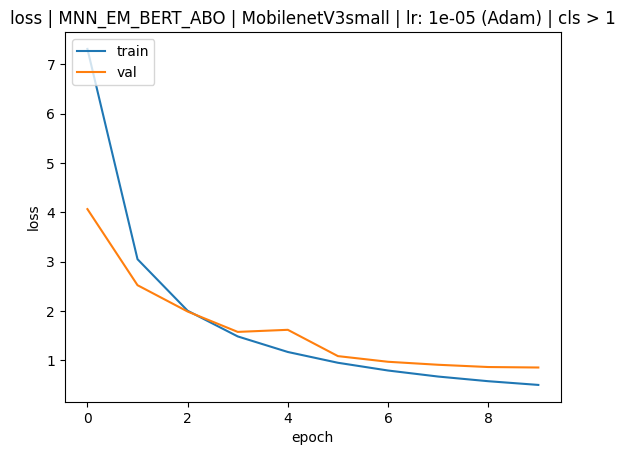

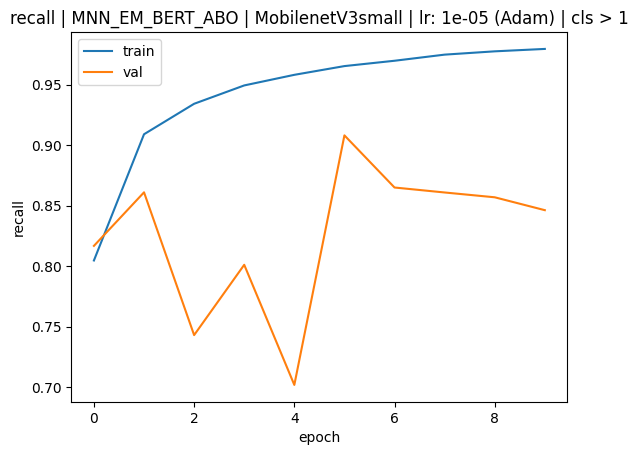

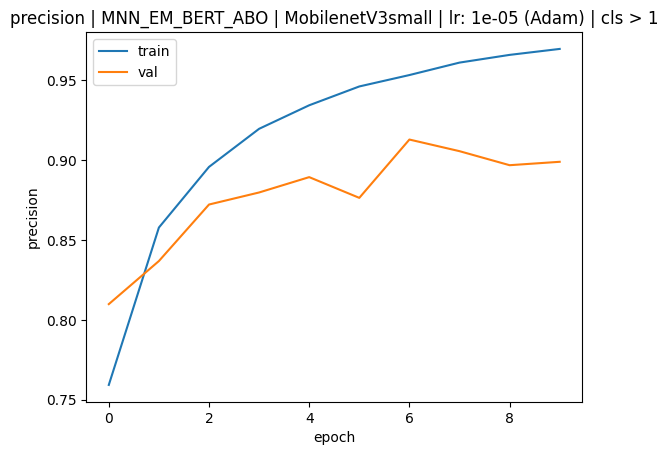

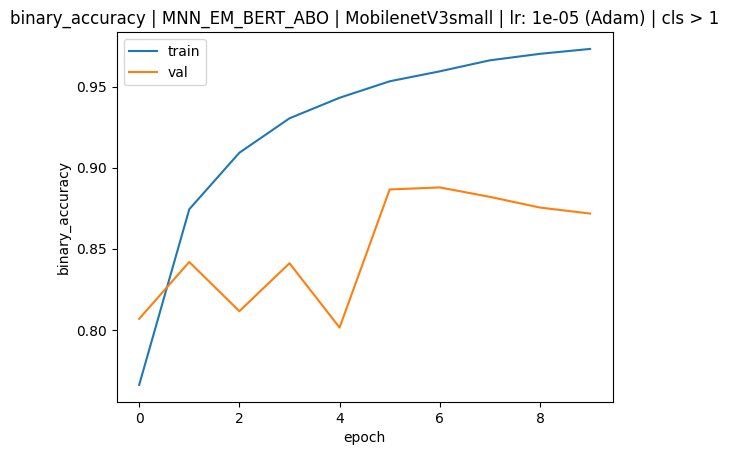

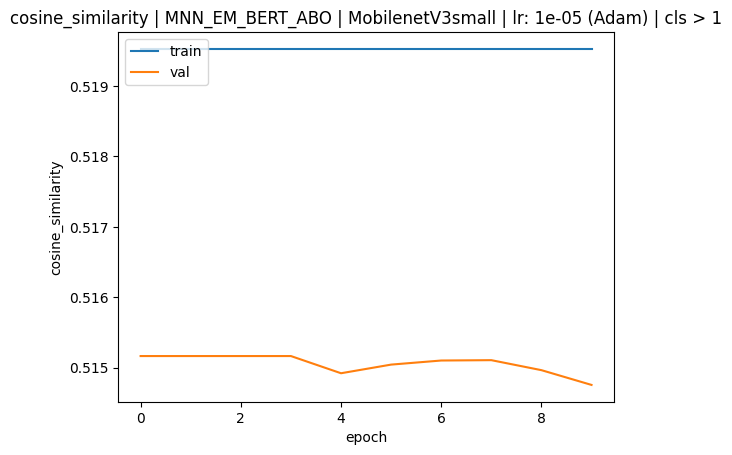

In [76]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [77]:
from utils.metrics import evaluate

In [78]:
evaluate(mnn_em.model, [img_test, text_test], labels_test, log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

16814/16814 [==============================] - 246s 15ms/step - loss: 0.8554 - recall: 0.8509 - precision: 0.8954 - binary_accuracy: 0.8696 - cosine_similarity: 0.5244
